In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
from sklearn.metrics import matthews_corrcoef

In [3]:
import cv2
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

In [4]:
from dataset_spliter import SplitByPatient
from metrics import *#F1Weighted, MCC
from losses import *
from data_loader import ImageItemListCell
from augmentation import cutout

In [5]:
from fastai.callbacks.hooks import  params_size
def extract_train_information(learner: Learner):
    #_, params, trainables, _ = params_size(learner.model)

    #total_params = sum(params)
    #trainable_ratio = sum([param*train for param, train in zip(params, trainables)]) / total_params * 100

    bs = learner.data.batch_size
    image_size = learner.data.valid_ds[0][0].size
    wd = learner.wd
    lr = max(learner.recorder.lrs)

    summary = ""
    #summary = "\nTotal params: {:,}".format(total_params)
    #summary += f"\nTrainable: {round(trainable_ratio,2)}%"
    summary += f"\nBs: {bs}"
    summary += f"\nwd: {wd}"
    summary += f"\nlr: {lr}"
    summary += f"\nImage: {image_size}\n"

    for tf in learner.data.train_dl.dl.dataset.tfms:
        summary += f"\n {tf}"
    
    return summary

In [6]:
path = Path('/data/Datasets/WhiteBloodCancer/train/')

In [7]:
np.random.seed(42)

In [8]:
fnames = get_image_files(path, recurse=True)
fnames[:5]

[PosixPath('/data/Datasets/WhiteBloodCancer/train/fold_1/hem/UID_H10_43_1_hem.bmp'),
 PosixPath('/data/Datasets/WhiteBloodCancer/train/fold_1/hem/UID_H22_31_15_hem.bmp'),
 PosixPath('/data/Datasets/WhiteBloodCancer/train/fold_1/hem/UID_H14_9_11_hem.bmp'),
 PosixPath('/data/Datasets/WhiteBloodCancer/train/fold_1/hem/UID_H14_28_6_hem.bmp'),
 PosixPath('/data/Datasets/WhiteBloodCancer/train/fold_1/hem/UID_H10_189_1_hem.bmp')]

In [9]:
hem_regex = re.compile(r'UID_(H[0-9]+)_', re.IGNORECASE)
all_regex = re.compile(r'UID_([0-9]+)_')

In [10]:
hem_patient_ids = list(set([hem_regex.search(str(fn)).group(1)
                            for fn in fnames if hem_regex.search(str(fn)) is not None]))
all_patint_ids = list(set([all_regex.search(str(fn)).group(1)
                           for fn in fnames if all_regex.search(str(fn)) is not None]))

hem_patients = dict((k,[]) for k in hem_patient_ids)
all_patints = dict((k,[]) for k in all_patint_ids)

[all_patints[key].append(fn) for key in all_patints.keys() for fn in fnames if 'UID_{0}_'.format(key) in str(fn)]
[hem_patients[key].append(fn) for key in hem_patients.keys() for fn in fnames if 'UID_{0}_'.format(key) in str(fn)]
print()

## Split data into train val 

In [11]:
split_handler = SplitByPatient(hem_patients, all_patints)

### Split by Fold

In [12]:
fold = 0

In [13]:
folds = split_handler.split_by_folds(5)

train_files = folds[1] + folds[2] + folds[3] + folds[4]
valid_files = folds[0]

In [14]:
print('Train Total: {0}'.format(len(train_files)))
print('Val Total: {0}'.format(len(valid_files)))

Train Total: 8994
Val Total: 1667


In [15]:
pat = re.compile(r'^.*(hem|all).bmp$')

def get_label(fn):
    return pat.search(str(fn)).group(1)

### Use just the cell

In [16]:
valid = ImageItemListCell(valid_files)
train = ImageItemListCell(train_files)

In [17]:
item_list = ItemLists(path, train, valid)
lls = item_list.label_from_func(get_label)

#### Data augmentation

In [18]:
cutout_fn = TfmLighting(cutout)
xtra_tfms=[squish(scale=0.66), cutout_fn(n_holes=5, length=0.2)]
tfms = get_transforms(do_flip=True, 
                      flip_vert=True, 
                      max_rotate=90,  
                      max_lighting=0.15, 
                      max_zoom=1.5, 
                      max_warp=0.2,
                      p_affine=0.75,
                      p_lighting=0.75,  
                      xtra_tfms=xtra_tfms,
                     )

#### Create dataset 

In [19]:
test_path = Path('/data/Datasets/WhiteBloodCancer/test/')

def get_data(bs, size):
    data  = ImageDataBunch.create_from_ll(lls, size=size, bs=bs, 
                                      ds_tfms=tfms, padding_mode='zeros',
                                      resize_method=ResizeMethod.PAD, test=test_path)
    data = data.normalize()
    #data = data.normalize((channel_mean, channel_std))
    return data
    

### Start training 256

In [20]:
experiment_name = 'rn18-cell-{}'.format(fold)

In [21]:
size = 450
bs = 128 

In [22]:
#gc.collect();

In [23]:
learn = create_cnn(get_data(bs, size), models.resnet18, 
                   metrics=[error_rate, F1Weighted(), MCC()],  
                   #loss_func=FocalLoss(num_classes=1, alpha=0.4, gamma=0.5),
                   #ps=0.75,
                   wd=0.001,
                   callback_fns=[ShowGraph, partial(SaveModelCallback, monitor="mcc", mode='max', name='stage1-{}-{}'.format(experiment_name, size))],
                  ).to_fp16().mixup()                

In [24]:
learn.callback_fns

[fastai.basic_train.Recorder,
 fastai.train.ShowGraph,
 functools.partial(<class 'fastai.callbacks.tracker.SaveModelCallback'>, monitor='mcc', mode='max', name='stage1-rn18-cell-0-450'),
 functools.partial(<class 'fastai.callbacks.mixup.MixUpCallback'>, alpha=0.4, stack_x=False, stack_y=True)]

In [25]:
#learn.lr_find()
#learn.recorder.plot()

In [26]:
lr = 1e-2

epoch,train_loss,valid_loss,error_rate,f1_weighted,mcc
1,0.647762,0.522543,0.262148,0.751867,0.470841
2,0.515733,0.358432,0.133773,0.867260,0.665932
3,0.477183,0.250646,0.085183,0.910057,0.779805
4,0.455197,0.294367,0.089382,0.907008,0.765931
5,0.433769,0.452356,0.176365,0.830152,0.603566
6,0.421318,0.273590,0.070786,0.929063,0.819429
7,0.409830,0.539110,0.241752,0.771686,0.540667
8,0.399656,0.361921,0.155969,0.850642,0.664924
9,0.389715,0.319876,0.122975,0.880637,0.716375
10,0.383080,0.327983,0.123575,0.880137,0.715950


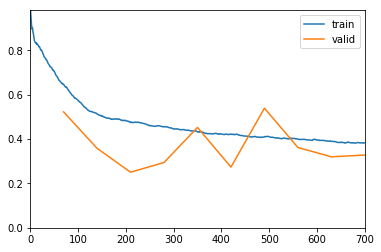


Bs: 128
wd: 0.001
lr: 0.01
Image: torch.Size([450, 450])

 RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1)}, p=1.0, resolved={'row_pct': 0.8308735837333175, 'col_pct': 0.02365797680899384, 'padding_mode': 'reflection'}, do_run=True, is_random=True)
 RandTransform(tfm=TfmAffine (dihedral_affine), kwargs={}, p=1.0, resolved={'k': 2}, do_run=True, is_random=True)
 RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={'magnitude': tensor([ 0.0753, -0.0279,  0.1362, -0.0434]), 'invert': False}, do_run=True, is_random=True)
 RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-90, 90)}, p=0.75, resolved={'degrees': -40.80709250396028}, do_run=True, is_random=True)
 RandTransform(tfm=TfmAffine (zoom), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'scale': (1.0, 1.5)}, p=0.75, resolved={'row_pct': 0.5207724073817909, 'col_pct': 0.5604686168909686, 'scale': 1.478307525884598}, do_run=True, is_random=True)
 Ran

In [27]:
learn.fit_one_cycle(10, lr) #, pct_start=0.8
print(extract_train_information(learn))

##### And fine-tune the whole model

In [28]:
learn.unfreeze()

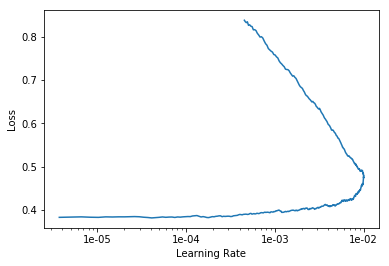

In [29]:
#learn.lr_find()
learn.recorder.plot()

In [30]:
learn.callback_fns[2] = partial(SaveModelCallback, 
                              monitor="mcc", 
                              mode='max', 
                              name='stage2-{}-{}'.format(experiment_name, size))

epoch,train_loss,valid_loss,error_rate,f1_weighted,mcc
1,0.399016,0.346622,0.129574,0.874543,0.704396
2,0.390055,0.273493,0.069586,0.930113,0.821841
3,0.389585,0.289471,0.111578,0.890922,0.734772
4,0.389520,0.234732,0.074385,0.925821,0.812129
5,0.381360,0.322340,0.127774,0.876678,0.714060
6,0.375592,0.265156,0.083983,0.916306,0.788207
7,0.371610,0.250328,0.085183,0.916023,0.791750
8,0.366849,0.280613,0.103779,0.898781,0.756291
9,0.363723,0.293790,0.109178,0.893323,0.741179
10,0.366758,0.269717,0.093581,0.907906,0.772411


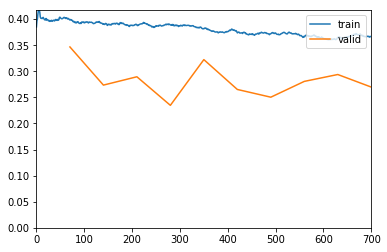


Bs: 128
wd: 0.001
lr: 0.0020000000000000005
Image: torch.Size([450, 450])

 RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1)}, p=1.0, resolved={'row_pct': 0.8308735837333175, 'col_pct': 0.02365797680899384, 'padding_mode': 'reflection'}, do_run=True, is_random=True)
 RandTransform(tfm=TfmAffine (dihedral_affine), kwargs={}, p=1.0, resolved={'k': 2}, do_run=True, is_random=True)
 RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={'magnitude': tensor([ 0.0753, -0.0279,  0.1362, -0.0434]), 'invert': False}, do_run=True, is_random=True)
 RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-90, 90)}, p=0.75, resolved={'degrees': -40.80709250396028}, do_run=True, is_random=True)
 RandTransform(tfm=TfmAffine (zoom), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'scale': (1.0, 1.5)}, p=0.75, resolved={'row_pct': 0.5207724073817909, 'col_pct': 0.5604686168909686, 'scale': 1.478307525884598}, do_run=True, is_

In [31]:
learn.fit_one_cycle(10, slice(1e-5,lr/5))
print(extract_train_information(learn))

In [32]:
preds_test, y_test=learn.get_preds(ds_type=DatasetType.Valid)# 
preds_test = np.argmax(torch.sigmoid(preds_test), axis=1)

In [33]:
score = int(matthews_corrcoef(y_test, preds_test) * 100)

In [34]:
learn.export('{}-{}-{}.pkl'.format(experiment_name, size, score))